In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import os, sys
import numpy as np
import math
from PIL import Image
#import cPickle as pkl
import _pickle as cPickle
import time
import tensorflow as tf
#import tensorflow.examples.tutorials.mnist.input_data as input_data
import glob
%matplotlib inline  
print ("Packages loaded")

Packages loaded


## Resize the images

In [5]:
path = "/home/saurabh/Documents/data/iccv09Data/images/"
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((90,90), Image.ANTIALIAS)
            imResize.save(f + '.jpg', 'JPEG', quality=90)
print("done")
resize()

done


# Load dataset

In [6]:
dirpath = "/home/saurabh/Documents/data/iccv09Data/images/"
#logs_path = "/home/saurabh/Documents/data/iccv09Data/images/"
height = 240
width  = 320
resize_ratio = 4
nr_img = 0
fileList = glob.glob(dirpath + '*.jpg')
for i, file in enumerate(fileList):
    img = Image.open(file)
    array = np.array(img) 
    if array.shape[0] == height and array.shape[1] == width:
        nr_img = nr_img + 1
        rgb = array.reshape(1, height, width, 3)
        imglow = img.resize((int(width/resize_ratio)
                ,int(height/resize_ratio)), Image.BICUBIC)
        imglow = imglow.resize((width, height), Image.BICUBIC)
        rgblow = np.array(np.float32(imglow)/255.)
        rgblow = rgblow.reshape(1, height, width, 3)
        rgb = np.reshape(rgb, [1, -1])
        rgblow = np.reshape(rgblow, [1, -1])
        if nr_img == 1:
            data = rgb
            datalow = rgblow
        else:
            data = np.concatenate((data, rgb), axis=0)
            datalow = np.concatenate((datalow, rgblow), axis=0)
        
print ("nr_img is %d" % (nr_img))
print ("Shape of 'data' is %s" % (data.shape,))
print ("Shape of 'datalow' is %s" % (datalow.shape,))

nr_img is 0


NameError: name 'data' is not defined

# Divide into two sets
## (xtrain, ytrain) and (xtest, ytest)

In [4]:
randidx = np.random.permutation(nr_img)
nrtrain = int(nr_img*0.7)
nrtest  = nr_img - nrtrain
xtrain  = datalow[randidx[0:nrtrain], :]
ytrain  = data[randidx[0:nrtrain], :]
xtest   = datalow[randidx[nrtrain:nr_img], :]
ytest   = data[randidx[nrtrain:nr_img], :]
print ("Shape of 'xtrain' is %s" % (xtrain.shape,))
print ("Shape of 'ytrain' is %s" % (ytrain.shape,))
print ("Shape of 'xtest' is %s" % (xtest.shape,))
print ("Shape of 'ytest' is %s" % (ytest.shape,))

Shape of 'xtrain' is (44, 230400)
Shape of 'ytrain' is (44, 230400)
Shape of 'xtest' is (19, 230400)
Shape of 'ytest' is (19, 230400)


# Plot some images

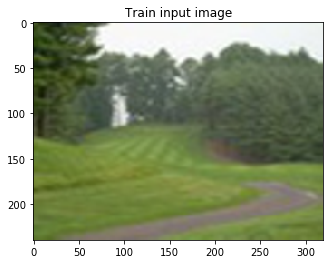

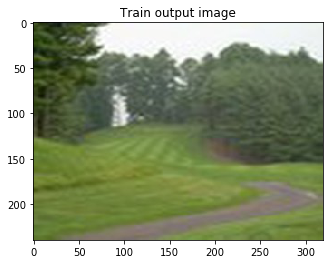

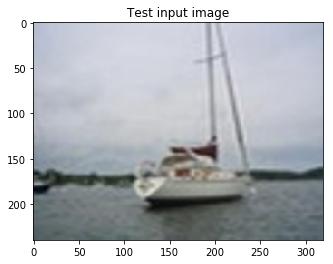

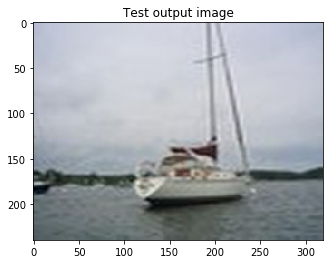

In [5]:
# Train
randidx = np.random.randint(nrtrain)
currx = xtrain[randidx, :]
currx = np.reshape(currx, [height, width, 3])
plt.imshow(currx)
plt.title("Train input image")
plt.show()
curry = ytrain[randidx, :]
curry = np.reshape(curry, [height, width, 3])
plt.imshow(curry)
plt.title("Train output image")
plt.show() 
# Test
randidx = np.random.randint(nrtest)
currx = xtest[randidx, :]
currx = np.reshape(currx, [height, width, 3])
plt.imshow(currx)
plt.title("Test input image")
plt.show()
curry = ytest[randidx, :]
curry = np.reshape(curry, [height, width, 3])
plt.imshow(curry)
plt.title("Test output image")
plt.show()

# Define network
# To Do: Save the weights

In [6]:
n1 = 32
n2 = 64
n3 = 64
n4 = 64
n5 = 64
n6 = 3
ksize = 3
fill = []
weights = {
    'ce1': tf.Variable(tf.random_normal([ksize, ksize, 3, n1],  stddev=0.01)),
    'ce2': tf.Variable(tf.random_normal([ksize, ksize, n1, n2], stddev=0.01)),
    'ce3': tf.Variable(tf.random_normal([ksize, ksize, n2, n3], stddev=0.01)),
    'ce4': tf.Variable(tf.random_normal([ksize, ksize, n3, n4], stddev=0.01)),
    'ce5': tf.Variable(tf.random_normal([ksize, ksize, n4, n5], stddev=0.01)),
    'ce6': tf.Variable(tf.random_normal([ksize, ksize, n5, n6],  stddev=0.01))
}
biases = {
    'be1': tf.Variable(tf.random_normal([n1], stddev=0.01)),
    'be2': tf.Variable(tf.random_normal([n2], stddev=0.01)),
    'be3': tf.Variable(tf.random_normal([n3], stddev=0.01)),
    'be4': tf.Variable(tf.random_normal([n4], stddev=0.01)),
    'be5': tf.Variable(tf.random_normal([n5], stddev=0.01)),
    'be6': tf.Variable(tf.random_normal([n6], stddev=0.01))
}
def srn(_X, _W, _b, _keepprob):
    _input_r = tf.reshape(_X, shape=[-1, height, width, 3])
    # Encoder
    _ce1 = tf.nn.relu(tf.add(tf.nn.conv2d(_input_r, _W['ce1']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be1']))
    _ce1 = tf.nn.dropout(_ce1, _keepprob)
    _ce2 = tf.nn.relu(tf.add(tf.nn.conv2d(_ce1, _W['ce2']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be2'])) 
    _ce2 = tf.nn.dropout(_ce2, _keepprob)
    _ce3 = tf.nn.relu(tf.add(tf.nn.conv2d(_ce2, _W['ce3']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be3'])) 
    _ce3 = tf.nn.dropout(_ce3, _keepprob)
    
    _ce4 = tf.nn.relu(tf.add(tf.nn.conv2d(_ce3, _W['ce4']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be4']))
    _ce4 = tf.nn.dropout(_ce4, _keepprob)
    _ce5 = tf.nn.relu(tf.add(tf.nn.conv2d(_ce4, _W['ce5']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be5'])) 
    _ce5 = tf.nn.dropout(_ce5, _keepprob)
    _ce6 = tf.nn.relu(tf.add(tf.nn.conv2d(_ce5, _W['ce6']
        , strides=[1, 1, 1, 1], padding='SAME'), _b['be6'])) 
    _out = _ce6 + _input_r
    
    #print(_ce6)
    print("The outpiut image is:",_out)
    fill.append(_out)
    

    return {'input_r': _input_r, 'ce1': _ce1, 'ce2': _ce2, 'ce3': _ce3
        , 'ce4': _ce4, 'ce5': _ce5, 'ce6': _ce6
        , 'layers': (_input_r, _ce1, _ce2, _ce3, _ce4, _ce5, _ce6)
        , 'out': _out}
print ("Network ready")


Network ready


# Define functions

In [7]:
dim = height*width*3
x = tf.placeholder(tf.float32, [None, dim])
y = tf.placeholder(tf.float32, [None, dim])
keepprob = tf.placeholder(tf.float32)
pred = srn(x, weights, biases, keepprob)['out']
pred_ce6 = srn(x, weights, biases, keepprob)['ce6']
cost = tf.reduce_mean(tf.square(srn(x, weights, biases, keepprob)['out'] 
            - tf.reshape(y, shape=[-1, height, width, 3])))

# Create a summary to monitor cost tensor
tf.summary.scalar("loss", cost)
merged_summary_op = tf.summary.merge_all()

learning_rate = 0.001
optm = tf.train.AdamOptimizer(learning_rate, 0.9).minimize(cost)
init = tf.initialize_all_variables()
print ("Functions ready")

The outpiut image is: Tensor("add:0", shape=(?, 240, 320, 3), dtype=float32)
The outpiut image is: Tensor("add_1:0", shape=(?, 240, 320, 3), dtype=float32)
The outpiut image is: Tensor("add_2:0", shape=(?, 240, 320, 3), dtype=float32)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Functions ready


# Run

In [ ]:
sess = tf.Session()
sess.run(init)
summary_writer = tf.summary.FileWriter('/tmp/tensorflow_logs', graph=sess.graph)

# Fit all training data
batch_size = 16
n_epochs   = 10000
recon_images = []
train_error = []
test_error = []
print("Strart training..")
randidx = np.random.randint(nrtrain, size=batch_size)
batch_xs = xtrain[randidx, :]
batch_ys = ytrain[randidx, :]
for epoch_i in range(n_epochs):
    for batch_i in range(nrtrain // batch_size):
        randidx = np.random.randint(nrtrain, size=batch_size)
        batch_xs = xtrain[randidx, :]
        batch_ys = ytrain[randidx, :]
        opt, summary = sess.run([optm,merged_summary_op], feed_dict={x: batch_xs, y: batch_ys, keepprob: 0.7})
    #if (epoch_i % 10) == 0:
        #print("==========>")
        #print ("[%02d/%02d] cost: %.4f" % (epoch_i, n_epochs
         #   , sess.run(cost, feed_dict={x: batch_xs
        #  , y: batch_ys, keepprob: 1.})))
        
        #########################summary_writer.add_summary(summary, epoch * total_batch + i)##############
        
        #summary = sess.run(merged_summary_op, feed_dict={x: batch_xs, y: batch_ys}) 
        total_batch = nrtrain // batch_size
        summary_writer.add_summary(summary, epoch_i * total_batch + batch_i)
       
    if (epoch_i % 10) == 0:
        print ("[%02d/%02d] cost: %.4f" % (epoch_i, n_epochs
            , sess.run(cost, feed_dict={x: batch_xs
            , y: batch_ys, keepprob: 1.})))
        n_examples = 2
        print ("Training dataset")
        randidx = np.random.randint(nrtrain, size=n_examples)
        train_xs = xtrain[randidx, :]
        train_ys = ytrain[randidx, :]
        recon = sess.run(pred, feed_dict={x: train_xs, keepprob: 1.})
        
        recon_ce6 = sess.run(pred_ce6, feed_dict={x: train_xs, keepprob: 1.})
        
        print("Fill i s: _OUT",fill)
        

        
        # Trainign error
        err1 = sess.run(cost, feed_dict = {x:batch_xs, y: batch_ys, keepprob: 1.})
        train_error.append(err1)
        #print("The train error is:", train_error)
        
        fig, axs = plt.subplots(3, n_examples, figsize=(15, 20))
        for example_i in range(n_examples):
            axs[0][example_i].imshow(np.reshape(
                train_xs[example_i, :], (height, width, 3)))
            axs[1][example_i].imshow(np.reshape(
                recon[example_i, :], (height, width, 3)))
            #axs[1][example_i].imshow(np.reshape(
                #recon_ce6[example_i, :], (height, width, 3)))
            axs[2][example_i].imshow(np.reshape(
                train_ys[example_i, :], (height, width, 3)))
        plt.show()
        print ("Test dataset")
        randidx = np.random.randint(nrtest, size=n_examples)
        test_xs = xtest[randidx, :]
        test_ys = ytest[randidx, :]
        recon = sess.run(pred, feed_dict={x: test_xs, keepprob: 1.})
        
        
        # Test Error
        err2 = sess.run(cost, feed_dict = {x: test_xs, y: test_ys, keepprob: 1.})
        test_error.append(err2)
        print("The test err is:",test_error)
        
        ########################gen_images = np.reshape(recon[epoch_i, :], (height, width, 3))
        
      
        fig, axs = plt.subplots(3, n_examples, figsize=(15, 20))
        for example_i in range(n_examples):
            axs[0][example_i].imshow(np.reshape(
                test_xs[example_i, :], (height, width, 3)))
            axs[1][example_i].imshow(np.reshape(
                recon[example_i, :], (height, width, 3)))
            recon_images.append(axs[1])
            axs[2][example_i].imshow(np.reshape(
                test_ys[example_i, :], (height, width, 3)))
        plt.show()
        #for i in range(0, recon_images):
            #print(recon_images[i])
            #print(i)
print("Training done. ")  
print("the train error is......")
plt.plot(train_error)
print("the TEST error is:......")
plt.plot(test_error)
plt.grid(True)
plt.show()
print ("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

Strart training..


# tensorboard --logdir=/tmp/tensorflow_logs¶
# Open http://localhost:6006/ on your web browser

## To Do: PSNR function and calculate psnr (LR, SR Image)


In [ ]:
def PSNRLoss(y_true, y_pred):
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    return -10. * np.log10(K.mean(K.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    assert y_true.shape == y_pred.shape, "Cannot calculate PSNR. Input shapes not same." \
                                         " y_true shape = %s, y_pred shape = %s" % (str(y_true.shape),
                                                                                   str(y_pred.shape))

    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))
